### Goal: Simple Regressions...

So what we want is some kind of regression like this exports on the change in tariffs. We will build on the mapping notebook, but need to extend it where the end result is a dataframe that is county by time, and has their exports per worker, tariff measure, need an employment measure to weight observations as well.

In [68]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
import numpy as np

import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import os  

#import weightedcalcs as wc
#import numpy as np

import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
from linearmodels.panel import PanelOLS

In [3]:
url = "https://data.bls.gov/cew/data/files/2017/csv/2017_annual_singlefile.zip"
# This will read in the annual, single file. It's big, but has all we want...

r = requests.get(url) 

# convert bytes to zip file  
bls_sf = zf.ZipFile(io.BytesIO(r.content)) 
print('Type of zipfile object:', type(bls_sf))

clist = ['area_fips', 'own_code', 'industry_code', 'agglvl_code', 'size_code',
       'year', 'disclosure_code', 'annual_avg_estabs',
       'annual_avg_emplvl', 'total_annual_wages','avg_annual_pay']

df = pd.read_csv(bls_sf.open(bls_sf.namelist()[0]), usecols= clist)

df.head()


Type of zipfile object: <class 'zipfile.ZipFile'>


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,area_fips,own_code,industry_code,agglvl_code,size_code,year,disclosure_code,annual_avg_estabs,annual_avg_emplvl,total_annual_wages,avg_annual_pay
0,1000,0,10,50,0,2017,NaN,124881,1936819,89088710816,45997
1,1000,1,10,51,0,2017,NaN,1208,53131,4339038631,81668
2,1000,1,102,52,0,2017,NaN,1208,53131,4339038631,81668
3,1000,1,1021,53,0,2017,NaN,610,11173,716001109,64083
4,1000,1,1022,53,0,2017,NaN,2,12,369309,30354


This cleans it up. **NEED to revist as the types and cuts are not doing what I want**

In [4]:
NAICS_county_level = 75 
# This is the code that will select only counties at the 4 digit NAICS level
#https://data.bls.gov/cew/doc/titles/agglevel/agglevel_titles.htm

df_county = df[df.agglvl_code == NAICS_county_level].copy()

df_county = df_county[df_county.own_code == 5]
# Only grab private stuff

df_county = df_county[(df_county.area_fips.str[0:2] != "72") & (df_county.area_fips.str[0:2] != "78")
              & (df_county.area_fips.str[0:2] != "02") & (df_county.area_fips.str[0:2] != "15")]
#Drop puerto rico, alaska, hawaii...

df_county["sup_ind"] = df_county.industry_code.str[1].astype(int)
# sometimes there are super industries floating around we want to drop them.
# not clear if this matters with the conditioning all ready

df_county = df_county[df_county["sup_ind"] > 0]

df_county.area_fips = df_county.area_fips.astype(str)

In [5]:
df_national = df_county.groupby("industry_code").agg({"annual_avg_emplvl": "sum"})

df_national.reset_index(inplace = True)

In [6]:
df_national.rename({"annual_avg_emplvl":"nat_emplvl"}, axis = 1, inplace = True)

---
#### The Trade Data

Key here is we keep the time-series

In [7]:
my_key = "&key=34e40301bda77077e24c859c6c6c0b721ad73fc7"

end_use = "hs?get=E_COMMODITY,CTY_CODE,ALL_VAL_MO,CTY_NAME"

url = "https://api.census.gov/data/timeseries/intltrade/exports/" + end_use + my_key + "&time==from+2017-01" + "&COMM_LVL=HS6"

url = url + "&CTY_CODE=5700"

r = requests.get(url) 

r

dftrade = pd.DataFrame(r.json()[1:]) # This then converts it to a dataframe
# Note that the first entry is the labels

dftrade.columns = r.json()[0]

dftrade.time = pd.to_datetime(dftrade.time, format="%Y-%m")
# This is so I can call this correctly...

dftrade.ALL_VAL_MO = dftrade.ALL_VAL_MO.astype(float)

dftrade.E_COMMODITY = dftrade.E_COMMODITY.astype(str)

dftrade.head(10)

dftrade.set_index("time", inplace = True)

Now create a annual 2017 `df` to create the weights. Then we need a modified time-series file to merge up. 

In [8]:
dftrade_17 = dftrade.loc["2017"].groupby("E_COMMODITY").agg({"ALL_VAL_MO":"sum"})

In [9]:
url = "https://www.census.gov/foreign-trade/reference/codes/concordance/expconcord17.xls"

df_concordance = pd.read_excel(url, dtype = {"commodity": str, "naics": str})

df_concordance["hs8"] = df_concordance.commodity.str[0:8]
# truncate down to get the hs8

df_concordance["hs6"] = df_concordance.commodity.str[0:6]
# truncate down to get the hs6

dict_concordance = dict(zip(df_concordance.hs6,df_concordance.naics)) 

# This creates a dictionaty from which we can map the hs6 to the naics codes

In [10]:
dftrade_17["hs6"] = dftrade_17.index

dftrade_17["naics"] = dftrade_17["hs6"].map(dict_concordance)

dftrade_17["naics4"] = dftrade_17["naics"].str[0:4]

dftrade_17["naics3"] = dftrade_17["naics"].str[0:3]

dftrade_17.rename({"ALL_VAL_MO":"2017_vals"}, axis = 1, inplace = True)

In [11]:
dftrade_17.head()

,2017_vals,hs6,naics,naics4,naics3
E_COMMODITY,,,,,
010121,29098.0,010121,112920,1129,112
010129,27975.0,010129,112920,1129,112
010130,11082.0,010130,112920,1129,112
010221,80280.0,010221,11211X,1121,112
010229,2682.0,010229,11211X,1121,112


In [12]:
dftrade["hs6"] = dftrade.E_COMMODITY

dftrade["naics"] = dftrade["hs6"].map(dict_concordance)

dftrade["naics4"] = dftrade["naics"].str[0:4]

dftrade["naics3"] = dftrade["naics"].str[0:3]

In [13]:
dftrade.head()

,E_COMMODITY,CTY_CODE,ALL_VAL_MO,CTY_NAME,COMM_LVL,CTY_CODE,hs6,naics,naics4,naics3
time,,,,,,,,,,
2017-01-01,854121,5700,4843669.0,CHINA,HS6,5700,854121,334413,3344,334
2017-01-01,710399,5700,3000.0,CHINA,HS6,5700,710399,339910,3399,339
2017-01-01,854231,5700,285025279.0,CHINA,HS6,5700,854231,334413,3344,334
2017-01-01,848490,5700,2372135.0,CHINA,HS6,5700,848490,339991,3399,339
2017-01-01,848710,5700,22596.0,CHINA,HS6,5700,848710,332999,3329,332


Now here is one of the harder parts we want to lawyer on the tariff data by product and time. So we will use the `map` function to exploit this. One concern is if the certain product codes overlap and how it is being treated, but I think this is 97 percent there. 

In [15]:
tariffs = pd.read_csv("tariff_list_naics.csv", dtype = {"HS-8 code": str,"HS6": str,"naics": str,"naics4": str})

tariffs.time_of_tariff = pd.to_datetime(tariffs.time_of_tariff, format="%Y-%m")

tariffs.set_index("time_of_tariff",inplace = True)

In [16]:
tariff_dict_r1 = dict(zip(tariffs.loc["2018-07-06"].HS6,tariffs.loc["2018-07-06"].tariff)) 

tariff_dict_r2 = dict(zip(tariffs.loc[dt.datetime(2018,8,23)].HS6,tariffs.loc[dt.datetime(2018,8,23)].tariff)) 

tariff_dict_r3 = dict(zip(tariffs.loc[dt.datetime(2018,9,24)].HS6,tariffs.loc[dt.datetime(2018,9,24)].tariff)) 

In [17]:
dftrade["tariff"] = 0

dftrade.loc["2018-07":,"tariff"] = dftrade.loc["2018-07":,"hs6"].map(tariff_dict_r1)

dftrade.loc["2018-09":,"tariff"] = dftrade.loc["2018-09":,"hs6"].map(tariff_dict_r2)

dftrade.loc["2018-10":,"tariff"] = dftrade.loc["2018-10":,"hs6"].map(tariff_dict_r3)

dftrade["tariff"] = dftrade["tariff"].replace(np.nan,0)

dftrade[dftrade["tariff"] == 25].head()

dftrade.head()

,E_COMMODITY,CTY_CODE,ALL_VAL_MO,CTY_NAME,COMM_LVL,CTY_CODE,hs6,naics,naics4,naics3,tariff
time,,,,,,,,,,,
2017-01-01,854121,5700,4843669.0,CHINA,HS6,5700,854121,334413,3344,334,0.0
2017-01-01,710399,5700,3000.0,CHINA,HS6,5700,710399,339910,3399,339,0.0
2017-01-01,854231,5700,285025279.0,CHINA,HS6,5700,854231,334413,3344,334,0.0
2017-01-01,848490,5700,2372135.0,CHINA,HS6,5700,848490,339991,3399,339,0.0
2017-01-01,848710,5700,22596.0,CHINA,HS6,5700,848710,332999,3329,332,0.0


Now merge it with the 2017 data so we can construct trade weighted averages of tariffs....

In [18]:
dftrade = dftrade.merge(dftrade_17["2017_vals"], how = "inner", left_on = "E_COMMODITY", right_index = True)

In [19]:
dftrade.head()


,E_COMMODITY,CTY_CODE,ALL_VAL_MO,CTY_NAME,COMM_LVL,CTY_CODE,hs6,naics,naics4,naics3,tariff,2017_vals
time,,,,,,,,,,,,
2017-01-01,854121,5700,4843669.0,CHINA,HS6,5700,854121,334413,3344,334,0.0,52779448.0
2017-02-01,854121,5700,4244421.0,CHINA,HS6,5700,854121,334413,3344,334,0.0,52779448.0
2017-03-01,854121,5700,6387293.0,CHINA,HS6,5700,854121,334413,3344,334,0.0,52779448.0
2017-04-01,854121,5700,4327898.0,CHINA,HS6,5700,854121,334413,3344,334,0.0,52779448.0
2017-05-01,854121,5700,4303254.0,CHINA,HS6,5700,854121,334413,3344,334,0.0,52779448.0


In [20]:
def trd_weighted_avg(df):
    # A function to create the trade weighted average of the tariff rates
    # by round...
    
    trd_w_avg = df["tariff"].multiply(df["2017_vals"],axis = 0).sum() 
    # here wuse the 2017 annual values to weight it
    
    trd_w_avg = trd_w_avg / df["2017_vals"].sum()
    
    foo = {"tariff_trd_w_avg": [trd_w_avg ], 
           "total_trade": df["ALL_VAL_MO"].sum()}
    
    return pd.DataFrame(foo)

In [25]:
grp = dftrade.groupby(["time","naics3"])

exp_trf_bynaics = grp.apply(trd_weighted_avg)

exp_trf_bynaics = exp_trf_bynaics.droplevel(2)

In [26]:
exp_trf_bynaics.loc["2018-8"].head()

tariff_trd_w_avg  total_trade
time       naics3                               
2018-08-01 111            24.663857  110625907.0
           112             0.250938    4354655.0
           113             0.000000  114574708.0
           114            23.283256  120036503.0
           211             0.000000  153466033.0

In [27]:
exp_trf_bynaics["time"] = exp_trf_bynaics.index.get_level_values(0)

In [28]:
exp_trf_bynaics = exp_trf_bynaics.droplevel(level=0)

In [29]:
exp_trf_bynaics.head()

,tariff_trd_w_avg,total_trade,time
naics3,,,
111,0.0,2.116828e+09,2017-01-01
112,0.0,2.636662e+06,2017-01-01
113,0.0,8.168255e+07,2017-01-01
114,0.0,4.815994e+07,2017-01-01
211,0.0,2.876446e+08,2017-01-01


---

### Merge Trade data with county data...

With the want being a dataframe that has county, time, export exposure and tariff exposure. 

In [30]:
grp = df_county.groupby("area_fips")

In [33]:
grp.get_group("1001").head()

,area_fips,own_code,industry_code,agglvl_code,size_code,year,disclosure_code,annual_avg_estabs,annual_avg_emplvl,total_annual_wages,avg_annual_pay,sup_ind
3016,1001,5,111,75,0,2017,N,4,0,0,0,1
3026,1001,5,112,75,0,2017,NaN,3,27,848146,31905,1
3033,1001,5,113,75,0,2017,NaN,4,36,2901165,80032,1
3040,1001,5,115,75,0,2017,NaN,9,27,2007731,74132,1
3052,1001,5,212,75,0,2017,N,4,0,0,0,1


In [34]:
def create_trade_weights(df):
    # Takes in the county groupings and will return, for each county, a time series of export
    # exposure, tariffs, and other statistics. 

    new_df = df.merge(df_national[["nat_emplvl",
                                   "industry_code"]],
                                  how = "outer", left_on = "industry_code", right_on = "industry_code")
    # Merge the nation with the county, why, we want to make sure all the naics codes are lined up properly
        
    new_df["emp_wts"] = (new_df.annual_avg_emplvl/new_df.nat_emplvl)
    # create the weights...
        
    foo_df = exp_trf_bynaics.merge(new_df[["emp_wts",
                                           "industry_code",
                                          "annual_avg_emplvl"]], left_index = True, right_on = "industry_code")
    
    # Now each weight is for a NAICS code, we will merge it with the export trade data set, so for all naics, all time...
    # This is a big df whith all trade data and then the county's weights for each naics code
    
    foo_grp = foo_df.groupby("time")
    
    # group by time. 
    
    foo = foo_grp.apply(trade_by_naics)
    
    # Then for each time gropuing, we aggregate across the naics codes according to the weights above.
    
    foo = foo.droplevel(1)
    
    foo["fips"] = df["area_fips"].astype(str).iloc[0]
    
    return pd.DataFrame(foo)
    

In [35]:
def trade_by_naics(df):
    # Simple function just to test about aggregation 
    exp_pc = (df["total_trade"]*df["emp_wts"]).sum()
    # multiply trade (by naics) by weight and then sum
    
    tafiff = (df["tariff_trd_w_avg"]*df["emp_wts"]).sum()
    # Same thing with the tariff
    
    foo = {"exp_pc": [exp_pc],
          "tariff": [tafiff],
          "emplvl_2017": df["annual_avg_emplvl"].sum()}

    return pd.DataFrame(foo)

In [72]:
trade_county = grp.apply(create_trade_weights)

In [41]:
#trade_county = trade_county.droplevel(0)

In [103]:
trade_county["chng_exp_pc"] = trade_county["exp_pc"].pct_change(12)

trade_county["chng_tariff"] = np.log(1+.01*trade_county["tariff"]).diff(12)

trade_county["log_tariff"] = np.log(1+.01*trade_county["tariff"])

trade_county["log_exp_pc"] = np.log(.11+trade_county["exp_pc"])

trade_county["const"] = 1

In [88]:
test = trade_county.dropna()

In [93]:
test.corr()

,exp_pc,tariff,emplvl_2017,chng_exp_pc,chng_tariff,const
exp_pc,1.000000,0.348981,0.924576,0.044416,0.232550,NaN
tariff,0.348981,1.000000,0.433464,-0.003020,0.712401,NaN
emplvl_2017,0.924576,0.433464,1.000000,0.036508,0.295118,NaN
chng_exp_pc,0.044416,-0.003020,0.036508,1.000000,-0.000156,NaN
chng_tariff,0.232550,0.712401,0.295118,-0.000156,1.000000,NaN
const,NaN,NaN,NaN,NaN,NaN,NaN


This is essentially it. Just need to tweak the index a bit, difference it, then we are ready to run some very simple regressions of change in export exposure on the change in tariffs

In [110]:
exog_vars = ["const",'log_tariff']

exog = trade_county[exog_vars]

mod = PanelOLS(trade_county.log_exp_pc, exog, entity_effects=True, time_effects = True)

fe_res = mod.fit(cov_type='clustered', cluster_entity=True)

print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:             log_exp_pc   R-squared:                        0.0027
Estimator:                   PanelOLS   R-squared (Between):              0.0012
No. Observations:               87804   R-squared (Within):              -0.0062
Date:                Fri, May 17 2019   R-squared (Overall):              0.0011
Time:                        21:37:52   Log-likelihood                -4.286e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      225.22
Entities:                        3252   P-value                           0.0000
Avg Obs:                       27.000   Distribution:                 F(1,84525)
Min Obs:                       27.000                                           
Max Obs:                       27.000   F-statistic (robust):             8.4835
                            

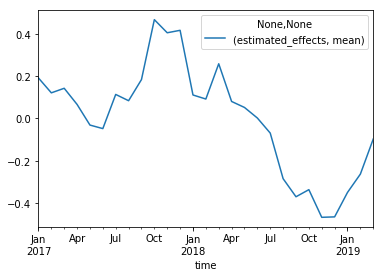

In [115]:
fe_res.estimated_effects.groupby("time").agg({"mean"}).plot()

In [116]:
fe_res.estimated_effects.mean()

estimated_effects   -1.002766e-15
dtype: float64

In [117]:
fe_res.summary

Dep. Variable:,log_exp_pc,R-squared:,0.0027
Estimator:,PanelOLS,R-squared (Between):,0.0012
No. Observations:,87804,R-squared (Within):,-0.0062
Date:,"Fri, May 17 2019",R-squared (Overall):,0.0011
Time:,21:37:52,Log-likelihood,-4.286e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,225.22
Entities:,3252,P-value,0.0000
Avg Obs:,27.000,Distribution:,"F(1,84525)"
Min Obs:,27.000,,
Max Obs:,27.000,F-statistic (robust):,8.4835
